# Analysis for calculating score for Alerts


## Getting and Preparing Data

This section loads sample data for 2015-05-21 records of activities, rules and actors.

In [541]:
%matplotlib inline

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import poisson
import json 
import math
import time
import collections
from pandas.tools.plotting import scatter_matrix
from collections import Counter
from datetime import datetime
from time import gmtime, strftime

### Activities

In [148]:
activities_cols_names = ["id","body", "country", "country_code", "place_type",
                       "sub_region", "actor_id", "source", "share_count",
                       "in_reply_to_native_id", "created_at", "updated_at",
                       "klout", "native_id", "verb", "latitude", "longitude",
                       "sharing_activity_native_id", "region", "favorites_count",
                       "replies_count", "in_reply_to_screen_name", "link"]

In [149]:
activities_relevant_cols = ["actor_id", "source", "share_count",
                           "in_reply_to_native_id", "created_at", "klout", 
                           "verb", "favorites_count", "replies_count"]

In [208]:
activities = pd.read_csv('https://s3.amazonaws.com/encoreanalytics-backups/db/production/data/2015-05-21-01-00-00_activities/b7d0c740-f270-4006-80b4-386041b71e8f.csv', 
                         header=None, parse_dates=True,
                         names=activities_cols_names, index_col="id")

In [209]:
activities = activities[activities_relevant_cols] 

In [210]:
activities['created_at'] = pd.to_datetime(activities['created_at'], format="%Y-%m-%d %H:%M:%S.%f")

In [211]:
activities.head()

,actor_id,source,share_count,in_reply_to_native_id,created_at,klout,verb,favorites_count,replies_count
id,,,,,,,,,
443640355408254904,2419819735,twitter,0,NaN,2015-05-21 01:00:00,48,post,0,0
443640355408254905,2405587887,twitter,0,NaN,2015-05-21 01:00:00,54,post,0,0
443640355408254907,2425857238,twitter,0,NaN,2015-05-21 01:00:00,31,post,0,0
443640355408254908,2422152815,twitter,9,NaN,2015-05-21 01:00:00,19,share,14,0
443640355408254909,2406991214,twitter,0,NaN,2015-05-21 01:00:00,35,post,0,0


In [212]:
activities.describe()

,share_count,klout,favorites_count
count,1.280768e+06,1.255925e+06,1280865.000000
mean,1.878510e+12,4.836412e+13,3338.222079
std,1.062963e+15,5.392960e+15,13146.340361
min,0.000000e+00,1.000000e+01,0.000000
25%,1.000000e+00,2.900000e+01,0.000000
50%,6.000000e+01,4.000000e+01,54.000000
75%,7.090000e+02,4.500000e+01,782.000000
max,6.015506e+17,6.015513e+17,462900.000000


### Actors

In [223]:
actors = pd.read_csv('https://s3.amazonaws.com/encoreanalytics-backups/db/production/data/2015-05-21-03-00-00_actors/d1e38bb1-89b5-407d-96d8-47c4ba33ba4f.csv', index_col="id")

In [224]:
actors.head()

,lang,favourites_count,statuses_count,friends_count,followers_count,listed_count
id,,,,,,
12,en,NaN,16636,1450,2984845,24425
767,en,24198,69163,2983,90600,4884
785,en,NaN,23948,846,14979,631
1952,en,94,41700,998,4043,226
2172,en,76,53560,2033,582423,12127


In [225]:
actors.describe()

,favourites_count,statuses_count,friends_count,followers_count,listed_count
count,72205.000000,734833.000000,734834.000000,734834.000000,734611.000000
mean,2063.706627,17198.639341,989.087618,3778.709121,32.093360
std,6821.231790,34693.571539,6001.745585,155812.787824,1135.065026
min,0.000000,0.000000,-438.000000,0.000000,0.000000
25%,36.000000,1385.000000,173.000000,133.000000,0.000000
50%,343.000000,5884.000000,358.000000,343.000000,2.000000
75%,1703.000000,18786.000000,779.000000,853.000000,7.000000
max,492244.000000,2051862.000000,1593446.000000,64199466.000000,821163.000000


### Alerts

In [226]:
alerts = pd.read_csv('data/alerts.csv', index_col="id")

In [227]:
alerts.head()

,business_id,options,created_at,updated_at,alert_type_id,type,rule_id
id,,,,,,,
173559,397,"{""klout_topics""=>""Baseball, College Baseball, ...",2015-05-21 00:00:15 -0400,2015-05-21 00:00:15 -0400,129,NaN,3454
173560,435,"{""klout_topics""=>""Sacramento, Twitter, San Jos...",2015-05-21 00:04:30 -0400,2015-05-21 00:04:30 -0400,129,NaN,4561
173561,439,"{""klout_topics""=>""Architecture, Interior Desig...",2015-05-21 00:09:26 -0400,2015-05-21 00:09:26 -0400,129,NaN,5183
173562,421,"{""hashtags""=>[""usocwithbdpc""], ""topic""=>""\""son...",2015-05-21 00:12:43 -0400,2015-05-21 00:12:43 -0400,118,HashtagAlert,4268
173563,369,"{""mean""=>""28.6667"", ""topic""=>""@pgatour"", ""vali...",2015-05-21 00:12:44 -0400,2015-05-21 00:12:44 -0400,142,PopularTopicAlert,2872


In [228]:
alerts.describe()

,business_id,alert_type_id,rule_id
count,620.000000,620.000000,620.000000
mean,307.483871,133.143548,3257.156452
std,155.333530,6.910251,1998.946054
min,1.000000,113.000000,20.000000
25%,224.000000,129.000000,1450.750000
50%,369.000000,129.000000,3616.000000
75%,443.000000,141.000000,5269.000000
max,453.000000,146.000000,5897.000000


### Activities for Alerted Trends for URLs

In [578]:
activities_urls = pd.read_csv('data/activities_urls_trends.csv', index_col="id")
activities_urls = activities_urls[activities_relevant_cols +["activities_count","rule_id", "alert_created_at","segment", "expanded_url"]]
activities_urls = activities_urls.sort("activities_count", ascending=False)
activities_urls['created_at'] = pd.to_datetime(activities_urls['created_at'], format="%Y-%m-%d %H:%M:%S")
activities_urls['alert_created_at'] = pd.to_datetime(activities_urls['alert_created_at'], format="%Y-%m-%d %H:%M:%S")

In [580]:
activities_urls.head()

,actor_id,source,share_count,in_reply_to_native_id,created_at,klout,verb,favorites_count,replies_count,activities_count,rule_id,alert_created_at,segment,expanded_url
id,,,,,,,,,,,,,,
443640355408832882,2424761055,twitter,671,NaN,2015-05-21 09:43:58,17,share,468,0,701,5852,2015-05-21 07:03:26,market,http://twitter.com/footy_jokes/status/60133160...
443640355408700115,2424174321,twitter,400,NaN,2015-05-21 07:02:32,25,share,246,0,701,5852,2015-05-21 07:03:26,market,http://twitter.com/footy_jokes/status/60133160...
443640355408701789,2424330443,twitter,407,NaN,2015-05-21 07:04:55,31,share,251,0,701,5852,2015-05-21 07:03:26,market,http://twitter.com/footy_jokes/status/60133160...
443640355408701608,2408455207,twitter,406,NaN,2015-05-21 07:04:38,34,share,251,0,701,5852,2015-05-21 07:03:26,market,http://twitter.com/footy_jokes/status/60133160...
443640355408701432,2426154688,twitter,405,NaN,2015-05-21 07:04:24,29,share,249,0,701,5852,2015-05-21 07:03:26,market,http://twitter.com/footy_jokes/status/60133160...


In [231]:
activities_urls.describe()

,actor_id,share_count,in_reply_to_native_id,klout,favorites_count,replies_count,activities_count
count,1.909000e+03,1909.000000,0,1893.000000,1909.000000,1909.000000,1909.000000
mean,2.178678e+09,259.558931,NaN,34.382990,189.161865,0.020430,432.473023
std,6.706268e+08,228.450609,NaN,11.030357,166.035460,0.523155,233.626166
min,1.819261e+06,0.000000,NaN,10.000000,0.000000,0.000000,12.000000
25%,2.407298e+09,79.000000,NaN,27.000000,35.000000,0.000000,194.000000
50%,2.415558e+09,191.000000,NaN,34.000000,159.000000,0.000000,446.000000
75%,2.423687e+09,390.000000,NaN,42.000000,311.000000,0.000000,701.000000
max,2.426304e+09,975.000000,NaN,90.000000,615.000000,21.000000,701.000000


In [152]:
# Activities for any URL (alerted or not)
activities_urls_full = pd.read_csv('data/activities_urls.csv')
activities_urls_full['created_at'] = pd.to_datetime(activities_urls_full['created_at'], format="%Y-%m-%d %H:%M:%S")

activities_urls_full.head()

,id,created_at,actor_id,source,share_count,in_reply_to_native_id,klout,verb,favorites_count,replies_count,expanded_url
0,443640355408457174,2015-05-21,2410305645,twitter,276,NaN,55,share,139,0,http://twitter.com/NoControlProjec/status/6011...
1,443640355408457177,2015-05-21,2425888166,twitter,75,NaN,43,share,42,0,https://www.youtube.com/watch?v=D1Xr-JFLxik&fe...
2,443640355408457177,2015-05-21,2425888166,twitter,75,NaN,43,share,42,0,http://twitter.com/ZIPERATIVO/status/601211950...
3,443640355408457178,2015-05-21,2414850561,twitter,236,NaN,17,share,310,0,http://twitter.com/Toshi_TNE/status/6011078230...
4,443640355408457179,2015-05-21,2426120314,twitter,13,NaN,17,share,11,0,http://twitter.com/GR8_2B_alive/status/6012094...


### Activities for Alerted Trends for Hashtags

In [608]:
activities_hashtags = pd.read_csv('data/activities_hashtags_trends.csv', index_col="id")
activities_hashtags = activities_hashtags[activities_relevant_cols +["activities_count","rule_id", "alert_created_at","segment", "hashtag"]]
activities_hashtags = activities_hashtags.sort("activities_count", ascending=False)
activities_hashtags['created_at'] = pd.to_datetime(activities_hashtags['created_at'], format="%Y-%m-%d %H:%M:%S")
activities_hashtags['alert_created_at'] = pd.to_datetime(activities_hashtags['alert_created_at'], format="%Y-%m-%d %H:%M:%S")

In [609]:
activities_hashtags.head()

,actor_id,source,share_count,in_reply_to_native_id,created_at,klout,verb,favorites_count,replies_count,activities_count,rule_id,alert_created_at,segment,hashtag
id,,,,,,,,,,,,,,
443640355408462636,66618379,twitter,855,NaN,2015-05-21 00:05:03,83,post,3437,6,582,5829,2015-05-21 00:37:45,market,kylekardashian
443640355408502966,2426126671,twitter,513,NaN,2015-05-21 00:58:10,39,share,1921,0,582,5829,2015-05-21 00:37:45,market,kylekardashian
443640355408514552,2424746967,twitter,538,NaN,2015-05-21 01:13:46,33,share,2049,0,582,5829,2015-05-21 00:37:45,market,kylekardashian
443640355408515240,2426128185,twitter,538,NaN,2015-05-21 01:14:54,28,share,2056,0,582,5829,2015-05-21 00:37:45,market,kylekardashian
443640355408515477,2410900451,twitter,539,NaN,2015-05-21 01:15:17,41,share,2057,0,582,5829,2015-05-21 00:37:45,market,kylekardashian


In [610]:
activities_hashtags.describe()

,actor_id,share_count,in_reply_to_native_id,klout,favorites_count,replies_count,activities_count,rule_id
count,2.791000e+03,2791.000000,6.900000e+01,2722.000000,2791.00000,2791.000000,2791.000000,2791.000000
mean,1.946889e+09,118.677177,6.014560e+17,39.397134,349.87818,0.007524,270.843784,3709.738087
std,8.819875e+08,196.281087,5.991670e+13,15.293138,734.20770,0.137622,198.897996,2366.267311
min,4.832230e+05,0.000000,6.012372e+17,10.000000,0.00000,0.000000,12.000000,115.000000
25%,2.404177e+09,0.000000,6.014636e+17,29.000000,0.00000,0.000000,99.000000,1164.000000
50%,2.412470e+09,7.000000,6.014680e+17,41.000000,4.00000,0.000000,213.000000,5470.000000
75%,2.422915e+09,166.500000,6.014719e+17,48.000000,278.00000,0.000000,402.000000,5829.000000
max,2.426303e+09,855.000000,6.015532e+17,99.000000,3437.00000,6.000000,582.000000,5895.000000


## Data Analysis

This section performs some data analysis over activities data in order to statistically measure the significance of variables.

### Regression Models ( for tweets only)

In [233]:
# Merge Activities and Actors data to build a regression model over it
regdata = pd.merge(activities[["share_count","klout","actor_id", "created_at", "verb"]], 
                   actors[["followers_count", "listed_count"]], 
                   left_on="actor_id", right_index=True)

# Add column with a float representation of hour and minute of activity
regdata["numeric_time"] = map(lambda t: float(t.hour) + float(t.minute)/60, 
                              regdata["created_at"].tolist())

In [234]:
def fit_regression_model(formula, data):
    # Fit regression model
    results = smf.ols(formula, data=data).fit()

    # Inspect the results
    print results.summary()
    

regdatatweetsonly = regdata[regdata["verb"]=="post"]
    
fit_regression_model('share_count ~ klout + followers_count + listed_count + numeric_time', regdatatweetsonly)

                            OLS Regression Results                            
Dep. Variable:            share_count   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     6224.
Date:                Fri, 05 Jun 2015   Prob (F-statistic):               0.00
Time:                        16:06:16   Log-Likelihood:            -3.7002e+05
No. Observations:               64741   AIC:                         7.401e+05
Df Residuals:                   64736   BIC:                         7.401e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           3.8318      0.973     

In [235]:
fit_regression_model('share_count ~ klout + numeric_time', regdatatweetsonly)

                            OLS Regression Results                            
Dep. Variable:            share_count   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     203.5
Date:                Fri, 05 Jun 2015   Prob (F-statistic):           7.62e-89
Time:                        16:06:19   Log-Likelihood:            -3.8035e+05
No. Observations:               64741   AIC:                         7.607e+05
Df Residuals:                   64738   BIC:                         7.607e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      -16.5413      1.111    -14.891   

### Scatter Matrix

array([[<matplotlib.axes.AxesSubplot object at 0x1326d1c90>,
        <matplotlib.axes.AxesSubplot object at 0x12de57690>]], dtype=object)

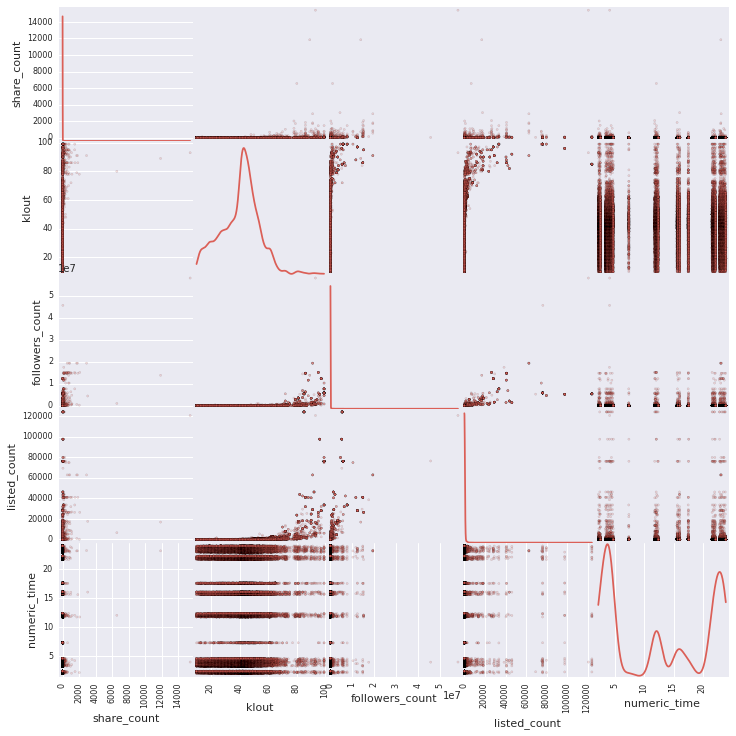

In [236]:
scatter_matrix(regdatatweetsonly, alpha=0.2, figsize=(12, 12), diagonal='kde')

array([[<matplotlib.axes.AxesSubplot object at 0x154d8add0>,
        <matplotlib.axes.AxesSubplot object at 0x156c502d0>]], dtype=object)

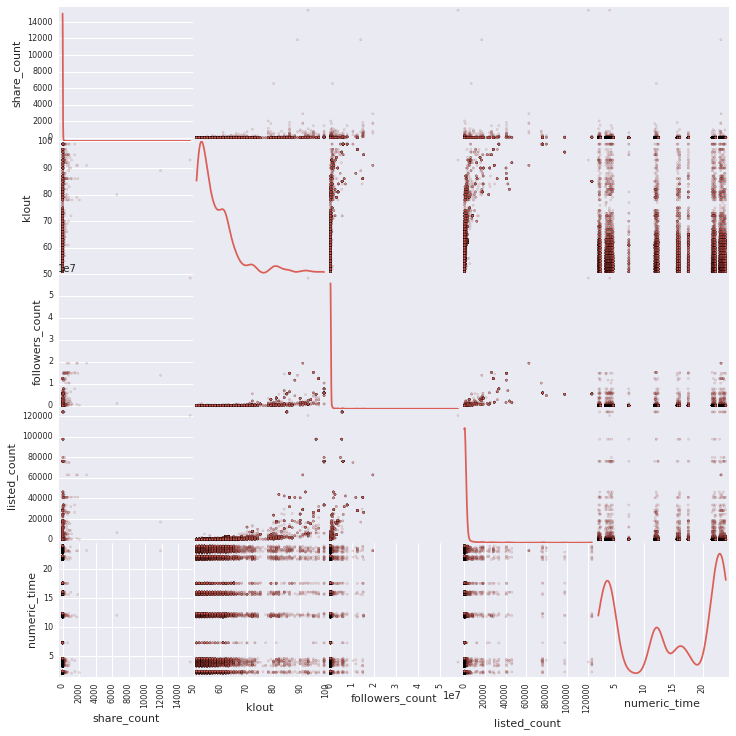

In [237]:
scatter_matrix(regdatatweetsonly[regdatatweetsonly["klout"]>50], alpha=0.2, figsize=(12, 12), diagonal='kde')

array([[<matplotlib.axes.AxesSubplot object at 0x135a425d0>,
        <matplotlib.axes.AxesSubplot object at 0x150c61ad0>]], dtype=object)

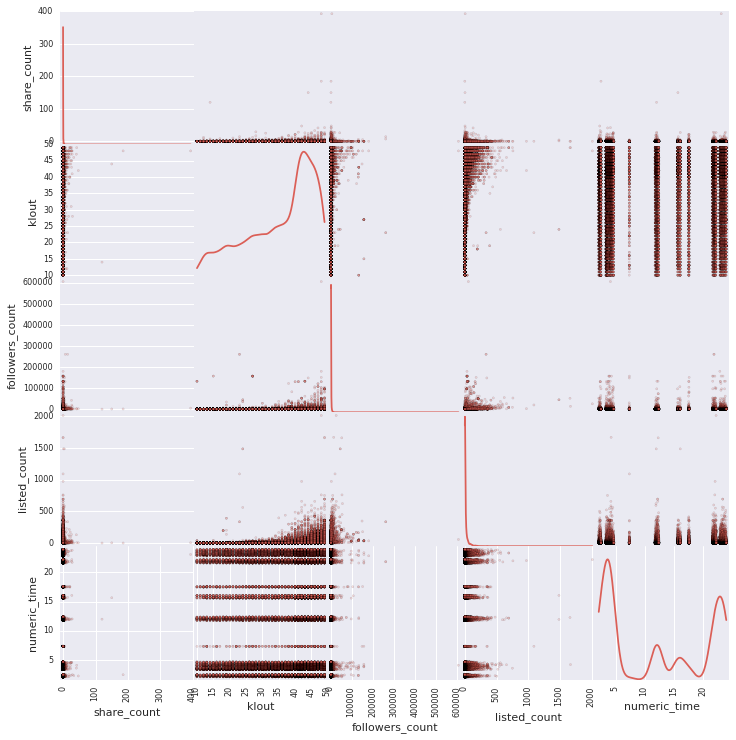

In [238]:
scatter_matrix(regdatatweetsonly[regdatatweetsonly["klout"]<50], alpha=0.2, figsize=(12, 12), diagonal='kde')

### Correlation Matrix

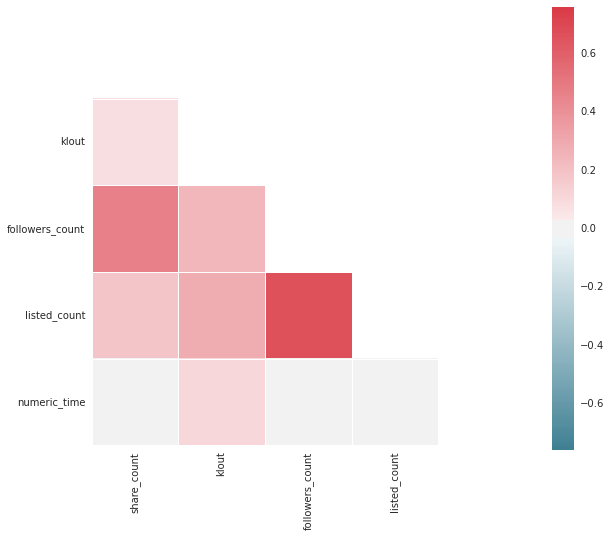

In [239]:
sns.set(style="darkgrid")

rs = np.random.RandomState(33)

f, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.corrplot(regdatatweetsonly, annot=False, sig_stars=False,
             diag_names=False, cmap=cmap, ax=ax)
f.tight_layout()

In [240]:
regdatatweetsonly[["klout", "followers_count", "listed_count", "share_count"]].corr()

,klout,followers_count,listed_count,share_count
klout,1.000000,0.241588,0.279210,0.078459
followers_count,0.241588,1.000000,0.660397,0.466239
listed_count,0.279210,0.660397,1.000000,0.187192
share_count,0.078459,0.466239,0.187192,1.000000


## Computing Scores

This section implements the functions for computing and the scores and performs some tests for subsequent validation.

### Alert type - Influencer


- Legend:
    - k = klout
    - f = followers
    - l = listed count
    - v = verb
    - kw = klout weight
    - fw = followers count weight
    - lw = listed count weight

- Values:
    - kw = 30
    - fw = 40
    - lw = 30
    - v = (tweet=1, retweet=0.9)

**influencer_score** = (2-v) \* kw \* (k^2) / 10000 +
                        v \* fw \* log(f) / 20 +
                        v \* lw \* log(l) / 15


In [241]:
def generate_influencer_score(activity_id, k=None, f=None, l=None, verb="post"):
    # Weights for klout, followers and lists
    kw = 30.0
    fw = 40.0
    lw = 30.0
    
    # Default behavior when activity_id is provided
    if activity_id is not None:
        activity = activities.loc[str(activity_id)]
        actor = actors.loc[int(activity.actor_id)]
        if not activity.klout.is_integer():
            k = 0.0
    
        # Obtain values from activity unless parameterized
        if k is None: k = float(activity.klout)
        if f is None: f = float(actor.followers_count + 1.0)
        if l is None: l = float(actor.listed_count + 1.0)
    
    # Coefficient for tweet(verb=post) or retweet(verb=share)
    v = 1.0 if verb=="post" else 0.9
    
    # Score calculation and return
    return int((2-v)*kw * float(k ** 2) / 10000 + \
                v * fw * math.log(f) / 20 + \
                v * lw * math.log(l) / 15)

In [242]:
for index, row in activities.head(30).iterrows():
    print "Generated score for activity {0}: {1}".format(index,generate_influencer_score(index))

Generated score for activity 443640355408254904: 29
Generated score for activity 443640355408254905: 22
Generated score for activity 443640355408254907: 20
Generated score for activity 443640355408254908: 7
Generated score for activity 443640355408254909: 18
Generated score for activity 443640355408254910: 14
Generated score for activity 443640355408254912: 28
Generated score for activity 443640355408254913: 7
Generated score for activity 443640355408254914: 30
Generated score for activity 443640355408254916: 23
Generated score for activity 443640355408254917: 12
Generated score for activity 443640355408254920: 30
Generated score for activity 443640355408254922: 16
Generated score for activity 443640355408254923: 22
Generated score for activity 443640355408254926: 12
Generated score for activity 443640355408254927: 47
Generated score for activity 443640355408254928: 16
Generated score for activity 443640355408254934: 57
Generated score for activity 443640355408254915: 42
Generated scor

Now testing with predefined values for evaluating limits:

In [243]:
generate_influencer_score(activity_id=None, k=99, f=50000000, l=50000000, verb='post')

100

In [244]:
generate_influencer_score(activity_id=None, k=90, f=50000000, l=50000000, verb='post')

95

In [245]:
generate_influencer_score(activity_id=None, k=99, f=50000000, l=50000000, verb='share')

96

In [246]:
generate_influencer_score(activity_id=None, k=90, f=50000000, l=50000000, verb='share')

90

In [247]:
generate_influencer_score(activity_id=None, k=70, f=5000000, l=5000000, verb='post')

76

In [248]:
generate_influencer_score(activity_id=None, k=70, f=5000000, l=5000000, verb='share')

71

In [249]:
generate_influencer_score(activity_id=None, k=50, f=5000000, l=5000000, verb='post')

69

In [250]:
generate_influencer_score(activity_id=None, k=50, f=5000000, l=5000000, verb='share')

63

In [251]:
generate_influencer_score(activity_id=None, k=50, f=1000000, l=1000000, verb='post')

62

In [252]:
generate_influencer_score(activity_id=None, k=50, f=1000000, l=1000000, verb='share')

57

### Alert type - Trending URLs and Hashtags
* Reach of tweets
* segment: marketing (categories: range from 1 to 10) vs business(15% more important than Marketing)

* Try to analyze: Potential, Virality

**trend_score** = reach + segment


In [336]:
top_urls = activities_urls_full[activities_urls_full["verb"]=="post"].sort(["share_count"], ascending=False)["expanded_url"]

In [668]:
def generate_numeric_time_list(data, field="created_at", timeframe=[]):
    time_list = data["created_at"].tolist()
    numeric_time_list = map(lambda t: float(t.hour) + float(t.minute)/60, time_list)
    
    if len(timeframe)==2:
        numeric_time_list = filter(lambda n: n >= timeframe[0] and n < timeframe[1], 
                                   numeric_time_list)
        numeric_time_list = map(lambda n: n - timeframe[0], numeric_time_list)
        
    return numeric_time_list


def calculate_score(entries, segment, limit=-1):
    #========================
    # print entries
    #========================
    
    entries = entries[:limit]
    
    peak = entries.max()
    decreases = map(lambda d: peak - d, entries)
    
    sqr_float = lambda x: x * x

    balanced_entries = map(lambda (i, e): round(float(e) * (1+sqr_float(math.log(i+1,2))), 3),
                           enumerate(entries))
    
    #========================
    print "Entries until alert: " + str(entries)
    print "Balanced entries until alert: " + str(balanced_entries)
    #========================
    
    segment_coef = 1.15 if segment=="business" else 1
    
    score = round(sum(balanced_entries)/limit, 3) * segment_coef
                             
    return score


def generate_trend_histogram(activities_param, timeframe=[],
                           title="Histogram for trending URL/Hashtag and Alert time", 
                           bins=150):

    numeric_time_list = generate_numeric_time_list(activities_param, 
                                                   timeframe=timeframe)
    
    alert_time_list = activities_param["alert_created_at"].tolist()
    numeric_alert_time_list = map(lambda t: (float(t.hour) + float(t.minute)/60), 
                                  alert_time_list)
    
    numeric_alert_time_list = map(lambda n: n - min(numeric_time_list), 
                                  numeric_alert_time_list)
    numeric_time_list = map(lambda n: n - min(numeric_time_list), numeric_time_list)
    numeric_time_list += [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    
    sns.set_palette("hls")
    entries, bin_edges, patches = plt.hist(numeric_time_list, bins=bins, range=[0.1, 24.0])

    alert_time = round(max(numeric_alert_time_list),2)
    alert_bin_position = round(float(max(numeric_alert_time_list))/24*bins,2)
    
    #========================
    segment = activities_param["segment"].tolist()[0]
    score_candidate = calculate_score(entries, segment, limit=int(alert_bin_position))
    print "Score candidate: " + str(score_candidate)
    print "Segment: " + segment
    print "Alert time: " + str(alert_time)
    print "Alert bin position: " + str(alert_bin_position)
    #========================
    
    plt.axvline(max(numeric_alert_time_list), color='b', linestyle='dashed', linewidth=2)
    mpl.rc("figure", figsize=(16, 4))
    plt.title(title)
    plt.show()

#### Trending URLs

Entries until alert: [ 133.   69.]
Balanced entries until alert: [133.0, 138.0]
Score candidate: 135.5
Segment: market
Alert time: 0.72
Alert bin position: 2.87


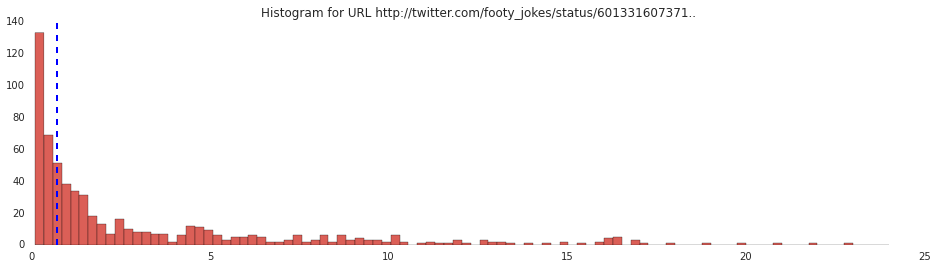

Entries until alert: [ 69.  40.  35.  14.  15.  14.   7.   8.   7.  16.  12.  18.   9.]
Balanced entries until alert: [69.0, 80.0, 122.924, 70.0, 95.87, 107.548, 62.169, 80.0, 77.339, 192.563, 155.612, 249.335, 132.239]
Score candidate: 132.21435
Segment: business
Alert time: 3.35
Alert bin position: 13.4


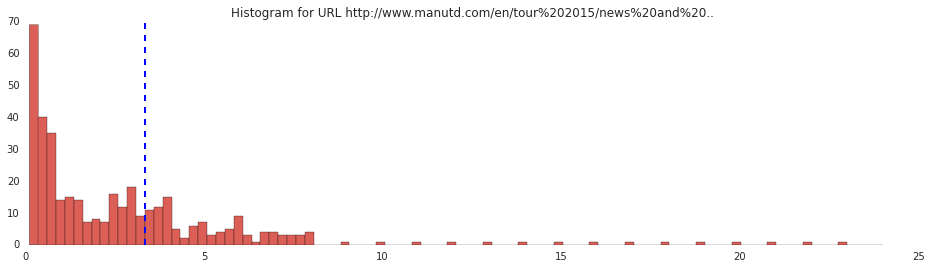

Entries until alert: [ 117.   36.   17.   13.]
Balanced entries until alert: [117.0, 72.0, 59.706, 65.0]
Score candidate: 90.19105
Segment: business
Alert time: 1.13
Alert bin position: 4.53


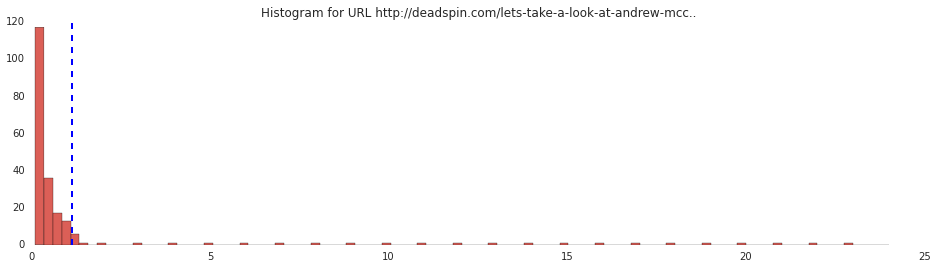

In [669]:
for url in ["http://twitter.com/footy_jokes/status/601331607371390976/photo/1",
            "http://www.manutd.com/en/tour%202015/news%20and%20features/2015/may/manchester%20united%20to%20face%20san%20jose%20earthquakes%20at%20california%20memorial%20stadium.aspx",
            "http://deadspin.com/lets-take-a-look-at-andrew-mccutchens-pay-stub-1706188663"]:
#            "https://twitter.com/perla69biebs/status/601239506763649025/video/1"]:
    acts = activities_urls[activities_urls["expanded_url"]==url]
    generate_trend_histogram(acts, bins=96, title="Histogram for URL "+url[:50]+"..")

#### Trending Hashtags

In [670]:
top_hashtags = activities_hashtags[activities_hashtags["verb"]=="post"].sort(["share_count"], ascending=False)["hashtag"]

Entries until alert: [ 108.   51.]
Balanced entries until alert: [108.0, 102.0]
Score candidate: 105.0
Segment: market
Alert time: 0.53
Alert bin position: 2.13


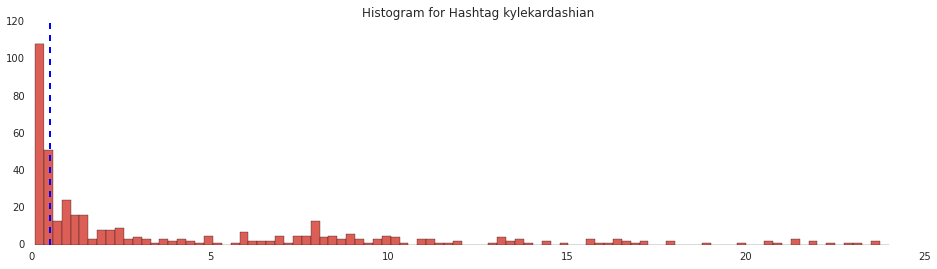

Entries until alert: [ 25.  19.  19.  13.  15.   5.   6.   7.   9.  24.   6.  14.]
Balanced entries until alert: [25.0, 38.0, 66.73, 65.0, 95.87, 38.41, 53.287, 70.0, 99.436, 288.845, 77.806, 193.927]
Score candidate: 92.693
Segment: market
Alert time: 3.02
Alert bin position: 12.07


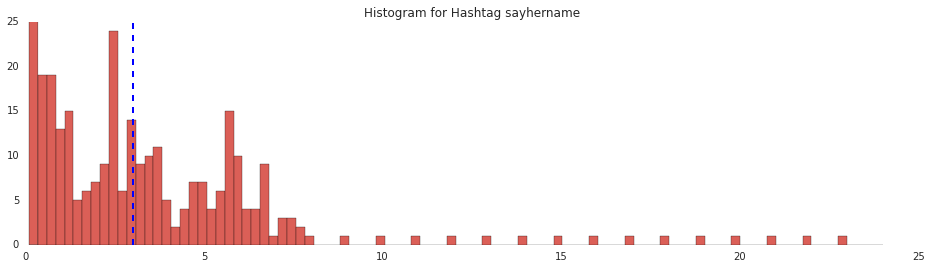

Entries until alert: [ 63.  37.  10.  20.   9.   3.  13.   8.   6.   3.   7.   1.   2.   0.   3.
   3.   2.   1.   0.   1.  14.]
Balanced entries until alert: [63.0, 74.0, 35.121, 100.0, 57.522, 23.046, 115.456, 80.0, 66.291, 36.106, 90.774, 13.852, 29.387, 0.0, 48.791, 51.0, 35.415, 18.388, 0.0, 19.679, 284.094]
Score candidate: 59.139
Segment: market
Alert time: 5.43
Alert bin position: 21.73


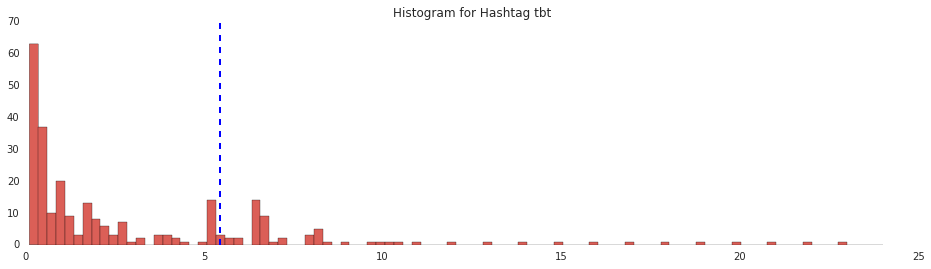

Entries until alert: [  2.   1.   2.   5.   3.   0.   2.   7.   1.   2.   0.   1.   0.   2.   3.
   1.   0.   0.   0.   1.   0.   0.   1.   1.   1.   0.   0.   2.   1.   5.
   2.   3.   1.   5.  12.  11.   6.   8.   2.  12.   2.  10.   6.   4.   2.
   5.   0.   2.   4.   5.   5.   5.   5.   2.   8.   7.  16.]
Balanced entries until alert: [2.0, 2.0, 7.024, 25.0, 19.174, 0.0, 17.762, 70.0, 11.048, 24.07, 0.0, 13.852, 0.0, 30.992, 48.791, 17.0, 0.0, 0.0, 0.0, 19.679, 0.0, 0.0, 21.463, 22.022, 22.565, 0.0, 0.0, 48.221, 24.6, 125.388, 51.088, 78.0, 26.446, 134.411, 327.715, 305.009, 168.83, 228.326, 57.871, 351.875, 59.407, 300.771, 182.666, 123.222, 62.321, 157.549, 0.0, 64.384, 130.1, 164.266, 165.882, 167.475, 169.045, 68.237, 275.393, 243.078, 560.362]
Score candidate: 91.165
Segment: market
Alert time: 14.42
Alert bin position: 57.67


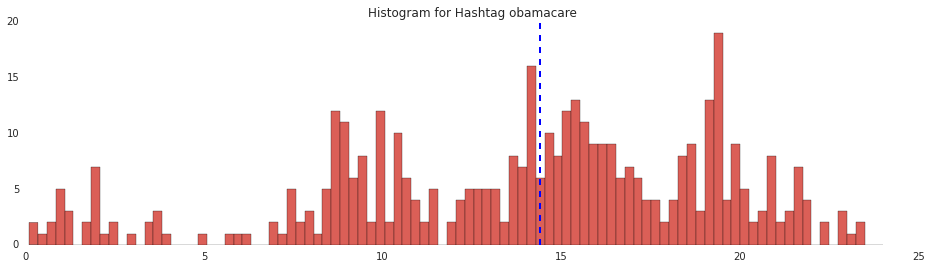

In [671]:
for htg in top_hashtags.tolist()[:4]:
    acts = activities_hashtags[activities_hashtags["hashtag"]==htg]
    generate_trend_histogram(acts, bins=96, title="Histogram for Hashtag "+htg)

In [138]:
def generate_histogram(activities_param, datetime_field="created_at", timeframe=[], title ="Histogram of Insights for trending URL and Alert time"):
    
    time_list = activities_param[datetime_field].tolist()
    numeric_time_list = map(lambda t: float(t.hour) + float(t.minute)/60, time_list)
    
    if len(timeframe)==2:
        numeric_time_list = filter(lambda n: n >= timeframe[0] and n < timeframe[1], numeric_time_list)

    sns.set_palette("hls")
    plt.hist(numeric_time_list, 150)
    mpl.rc("figure", figsize=(16, 4))
    plt.title(title)
    return plt    

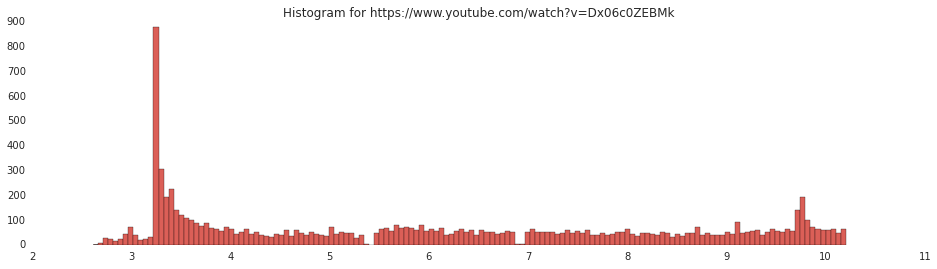

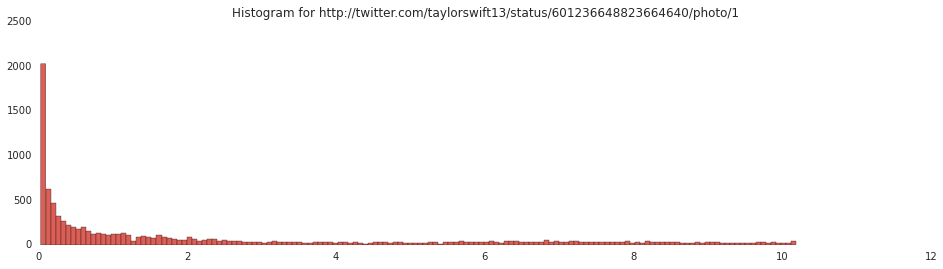

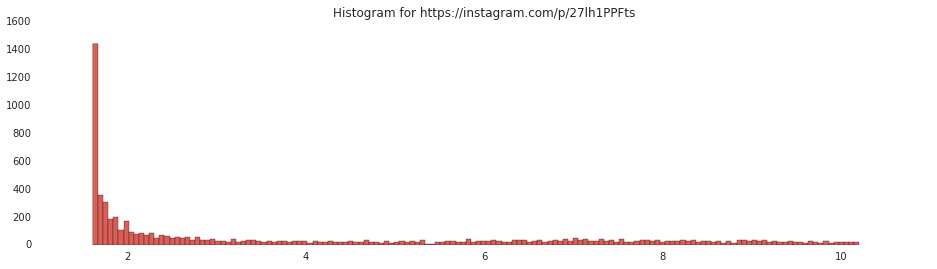

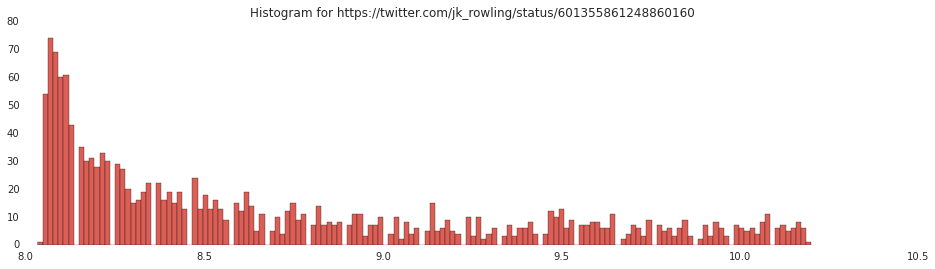

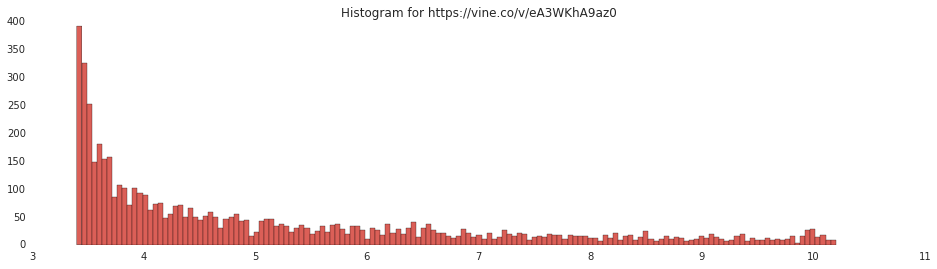

In [261]:
for url in top_urls.head(10).tolist():
    plot_ac = activities_urls_full[activities_urls_full["expanded_url"]==url]
    if len(plot_ac) > 10:
        acts = activities_urls_full[activities_urls_full["expanded_url"]==url]
        generate_histogram(acts, title="Histogram for " + url).show()

In [32]:
def count_original_tweet(url_param):
    return len(activities_urls_full[activities_urls_full["expanded_url"]==url_param][activities_urls_full["verb"]=="post"])

In [46]:
for url in top_urls.head(50).tolist():
    print url, count_original_tweet("https://instagram.com/p/27lh1PPFts")

https://www.youtube.com/watch?v=Dx06c0ZEBMk 1
http://twitter.com/taylorswift13/status/601236648823664640/photo/1 1
http://twitter.com/abandonedpics/status/601319432472887296/photo/1 1
https://instagram.com/p/27lh1PPFts 1
https://twitter.com/jk_rowling/status/601355861248860160 1
https://vine.co/v/eA3WKhA9az0 1
http://twitter.com/Letterman/status/601249258562551808/photo/1 1
http://twitter.com/TrayTraysince81/status/601387051469017088/photo/1 1
http://www.vevo.com/watch/USCJY1531563?sf833455=1 1
http://twitter.com/Vevo/status/601382295023525888/photo/1 1
http://twitter.com/FemaIeFeelings/status/601379800268283904/video/1 1
http://twitter.com/Footy_Jokes/status/601372323539726337/photo/1 1
http://twitter.com/FCBarcelona/status/601353120246018048/photo/1 1
http://twitter.com/GLOBEXDIGITAL/status/601275796573978625/photo/1 1
https://www.youtube.com/watch?v=kDWZNWgIqxs&feature=youtu.be 1
http://www.sugarscape.com/music/news/a1078122/one-direction-song-of-summer 1
http://twitter.com/sugarsca

In [349]:
calculate_kurtosis(activities_urls_full[activities_urls_full["expanded_url"]=="https://www.youtube.com/watch?v=Dx06c0ZEBMk"])

97.84663083891374

In [134]:
for url in top_urls.head(10).tolist():
    plot_ac = activities_urls_full[activities_urls_full["expanded_url"]==url]
    if len(plot_ac) > 10:
        print url, calculate_rate_of_decrease(activities_urls_full[activities_urls_full["expanded_url"]==url], "created_at")

https://www.youtube.com/watch?v=Dx06c0ZEBMk None
http://twitter.com/taylorswift13/status/601236648823664640/photo/1 None
https://instagram.com/p/27lh1PPFts None
https://twitter.com/jk_rowling/status/601355861248860160 None
https://vine.co/v/eA3WKhA9az0 None


### Alert type - Popular Tweet
* Engagement of tweet (RT + Favorites)
* Potential of engagement (mean(RT + Favorites) * len(tweets_per_day))

**popular_score** = engagement + potential




In [ ]:
# TODO